Step 1: Library & Data Load

In [217]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tabulate import tabulate
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier


datalink = "https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/Employee_Attrition_Data_Set.csv"

# Read the data file
df = pd.read_csv(datalink)

Step 2: Drop Unnecessary Employee ID Column

Explanation: Employee ID is not useful for our purposes, so it is removed to focus on the rest of the columns.

In [218]:
# Drop unnecessary Employee ID Column
columns_to_drop = ['Employee ID'] 
df.drop(columns=columns_to_drop, inplace=True)

Step 3: Convert Target Variable to Binary 0/1
Explanation: Easier to deal with later on.

In [219]:
# List of values to match
Yes_Check = ['Yes']

# Convert text values to 1 if they match with Yes, else 0
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x in Yes_Check else 0)

Step 4: Quick Hygiene and Data Structure Check

Explanation: Before any feature engineering or further EDA, would like to check if there are any nulls in the data, which columns are categorical, which are not, and the min/max/mean/etc of each. This will provide us a better idea on what to visualize next in the EDA.

Result: We can see that there are no nulls in the data, which is good. There are also no major outliers in the data that requires winsorization. We can also clearly see some categorical columns that will require one hot encoding to be used in the model.

In [220]:
# Check for null values
null_counts = df.isnull().sum()
null_percentages = 100 * df.isnull().sum() / len(df)

# Combine the counts and percentages into a single dataframe
null_table = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])

# Sort the table by null count in descending order
null_table = null_table.sort_values('Null Count', ascending=False)

# Display only columns with null values
print(null_table[null_table['Null Count'] > 0])

# If there are no null values, print a message
if null_table['Null Count'].sum() == 0:
    print("There are no null values in the dataset.")

# Quick summary of data
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-Null Count': df.notnull().sum(),
        'Null Count': df.isnull().sum(),
        'Unique Values': df.nunique(),
        'First Value': df.iloc[0],
        'Second Value': df.iloc[1],
        'Third Value': df.iloc[2]
    })
    
    summary['Null Percentage'] = (100 * summary['Null Count'] / len(df)).round(1)
    
    return summary

# Get the summary of the DataFrame
summary_df = df.describe(include='all').transpose()

# Add additional information
summary_df['Null Count'] = df.isnull().sum()
summary_df['Null Percentage'] = (100 * df.isnull().sum() / len(df)).round(1)
summary_df['Data Type'] = df.dtypes

# Reorder columns for readability
summary_df = summary_df[['Data Type', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Null Count', 'Null Percentage']]

print(summary_df)

Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []
There are no null values in the dataset.
                      Data Type    count       mean          std     min  \
Age                       int64  10000.0    40.5612    10.876483    22.0   
Gender                   object    10000        NaN          NaN     NaN   
Job Role                 object    10000        NaN          NaN     NaN   
Department               object    10000        NaN          NaN     NaN   
Monthly Income            int64  10000.0  8948.7503  3473.354793  3000.0   
Years at Company          int64  10000.0    14.3111     8.742572     0.0   
Number of Promotions      int64  10000.0     1.9583     1.426171     0.0   
Last Raise Percentage   float64  10000.0  10.022797     5.823696     0.0   
Distance from Office    float64  10000.0  26.632481    14.396393     1.0   
Job Satisfaction          int64  10000.0      5.407     2.943504     1.0   
Performance Rating        int64  10000.0     2.9929     1.

Step 5: Initial EDA and Checking Distribution

Explanation: Need to check if there is a class imbalance in the data, as that will affect model performance and tuning. Need to also check how other features are distributed to guide any future feature engineering.

Result: There is a heavy class imbalance, which means there are very few people who left the company versus those who stayed. This will likely mean that our model will struggle with either Recall or Precision of 1 without tuning. Other columns seem rather evenly distributed in their data.

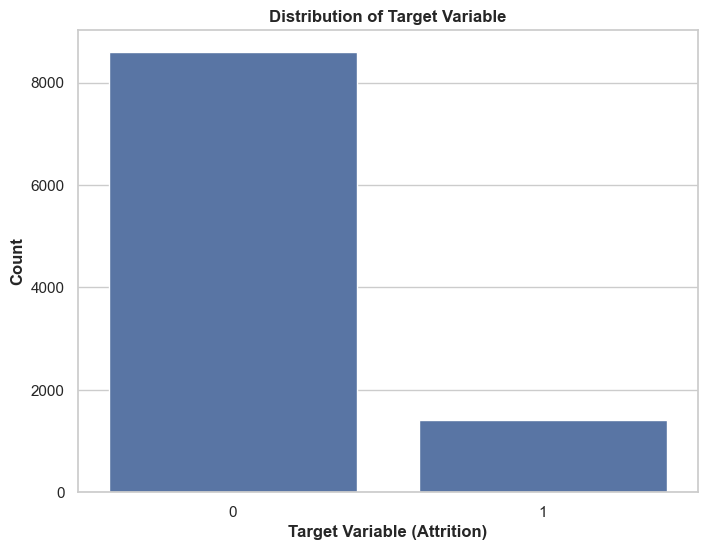

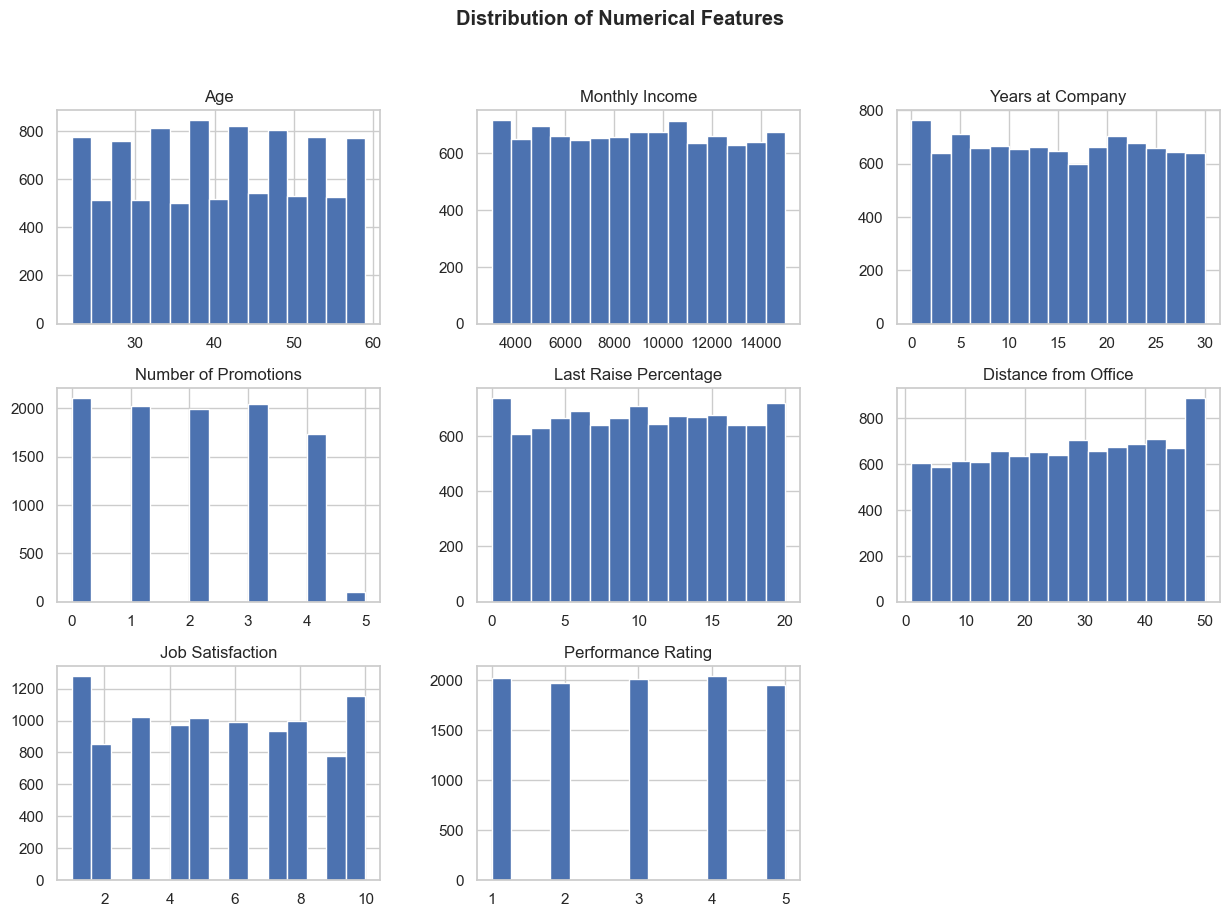

In [221]:
# Set plot style
sns.set_theme(style="whitegrid")

# Function to bin data
def bin_data(data, bins, labels):
    return pd.cut(data, bins=bins, labels=labels, include_lowest=True)

# Add a Got Promoted Binary column (This might be more powerful to use rather than how many times one gets promoted)
df['Got Promoted'] = df['Number of Promotions'].apply(lambda x: 1 if x > 0 else 0)

# 1. Distribution of the target variable
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Attrition', data=df)  

plt.title('Distribution of Target Variable', fontweight='bold')
plt.xlabel('Target Variable (Attrition)', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.show()

# 2. Distribution of numerical features
numerical_features = ['Age','Monthly Income','Years at Company', 'Number of Promotions', 'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 'Performance Rating']
df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distribution of Numerical Features', fontweight='bold')
plt.show()

Step 6: Calculating Correlation Matrix

Explanation: Quick way to identify if certain features have correleations.

Results: Not much to see here. The 0.71 is meaningless since Got Promoted got calculated using Number of Promotions.

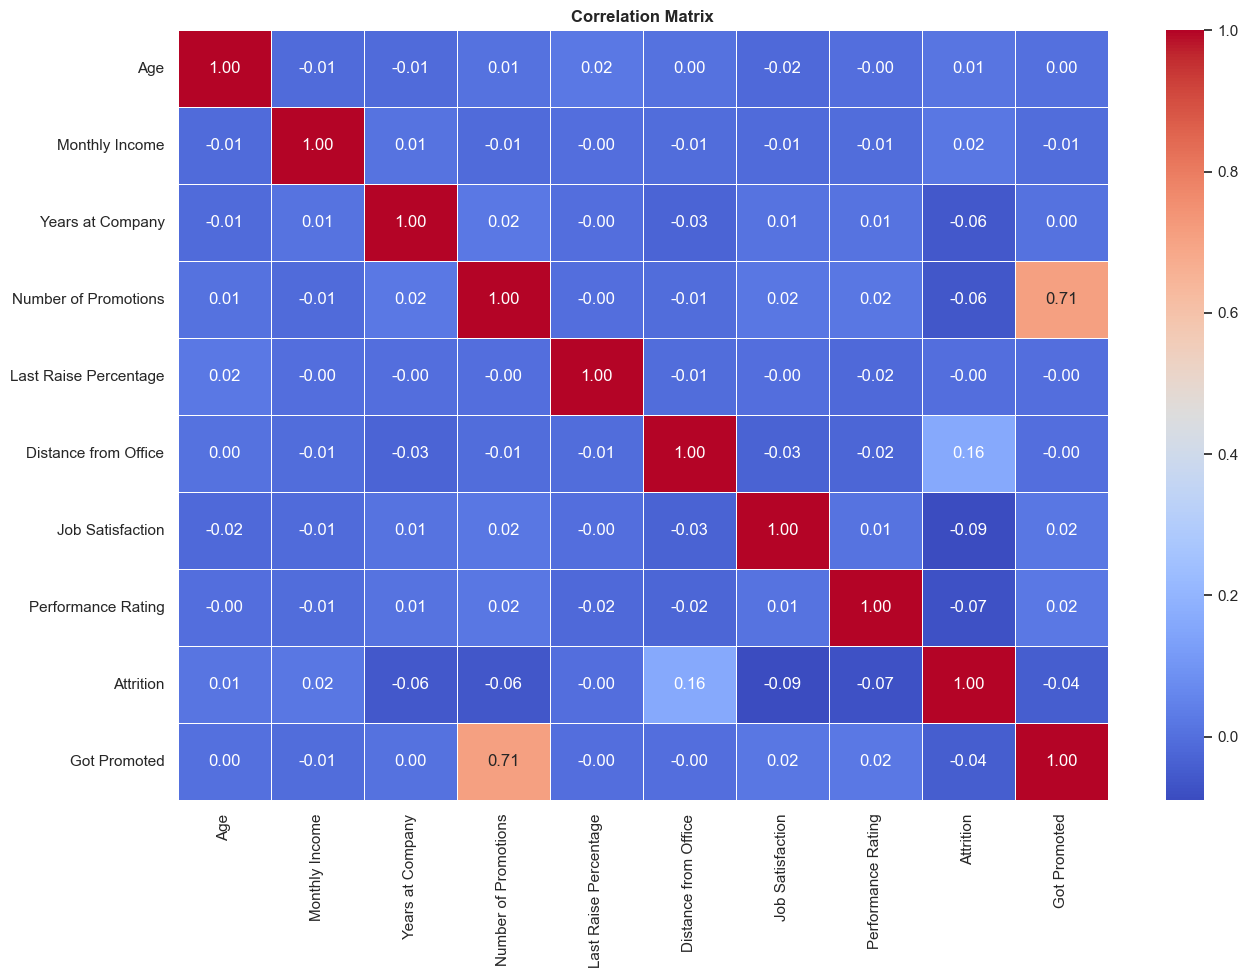

In [222]:
# Calculating Correlation Matrix
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns
corr_df = df[numeric_columns]

plt.figure(figsize=(15, 10))
corr = corr_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontweight='bold')
plt.show()

Step 7: Binning certain Columns and Further EDA

Explanation: Binning is required to plot some charts meaningfully, so columns with lots of values in them are grouped in logical "buckets". Furthermore, plotting these against the target variable will give initial impressions on which features are likely to predict Attrition.

Result: Job Staisfaction, Performance Ratings, as well as Distance seem to have an influence on Attrition. The further you are, the more likely you will leave. The higher job satisfaction and performance ratings you have, the more likely you are to stay. Tenure shows some promise as well, but nothing too strong. The other features did not seem to showcase anything else at first glance. This doesn't mean that they won't be useful, but that they individually do not tell us much. 


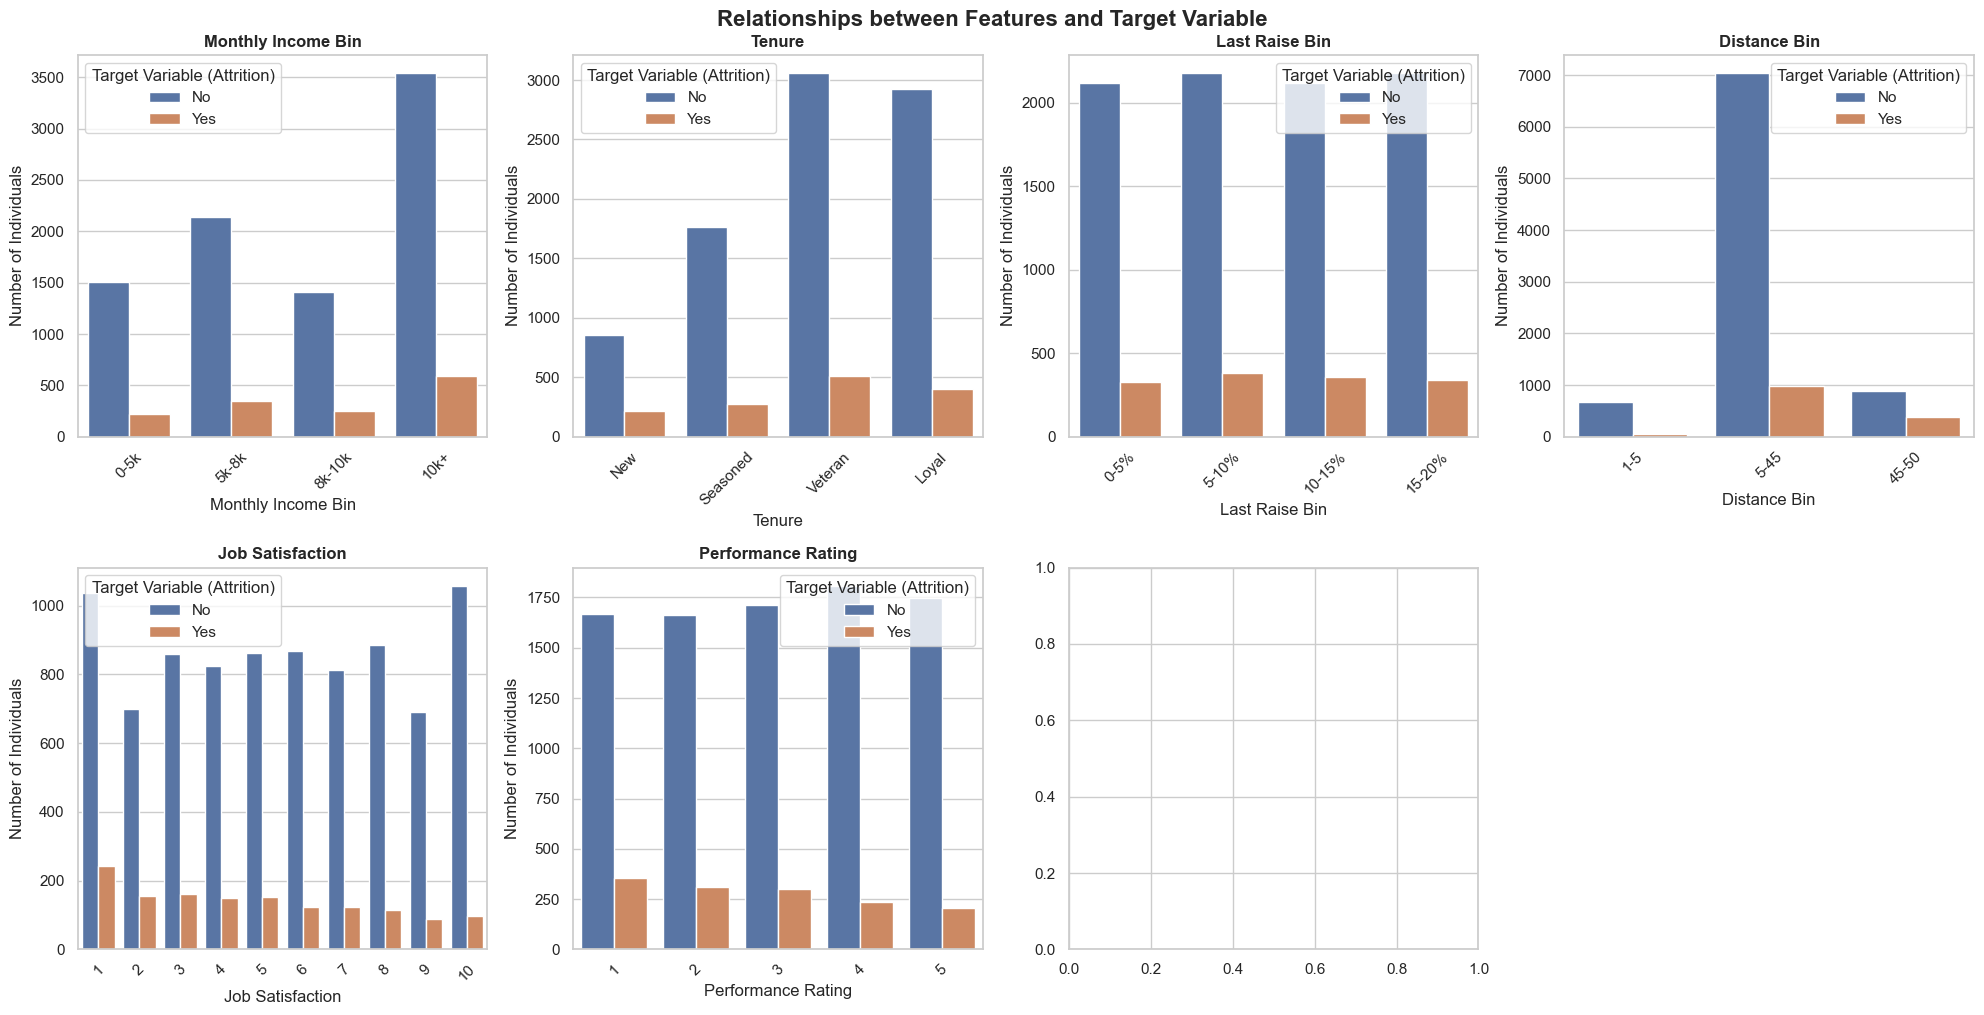

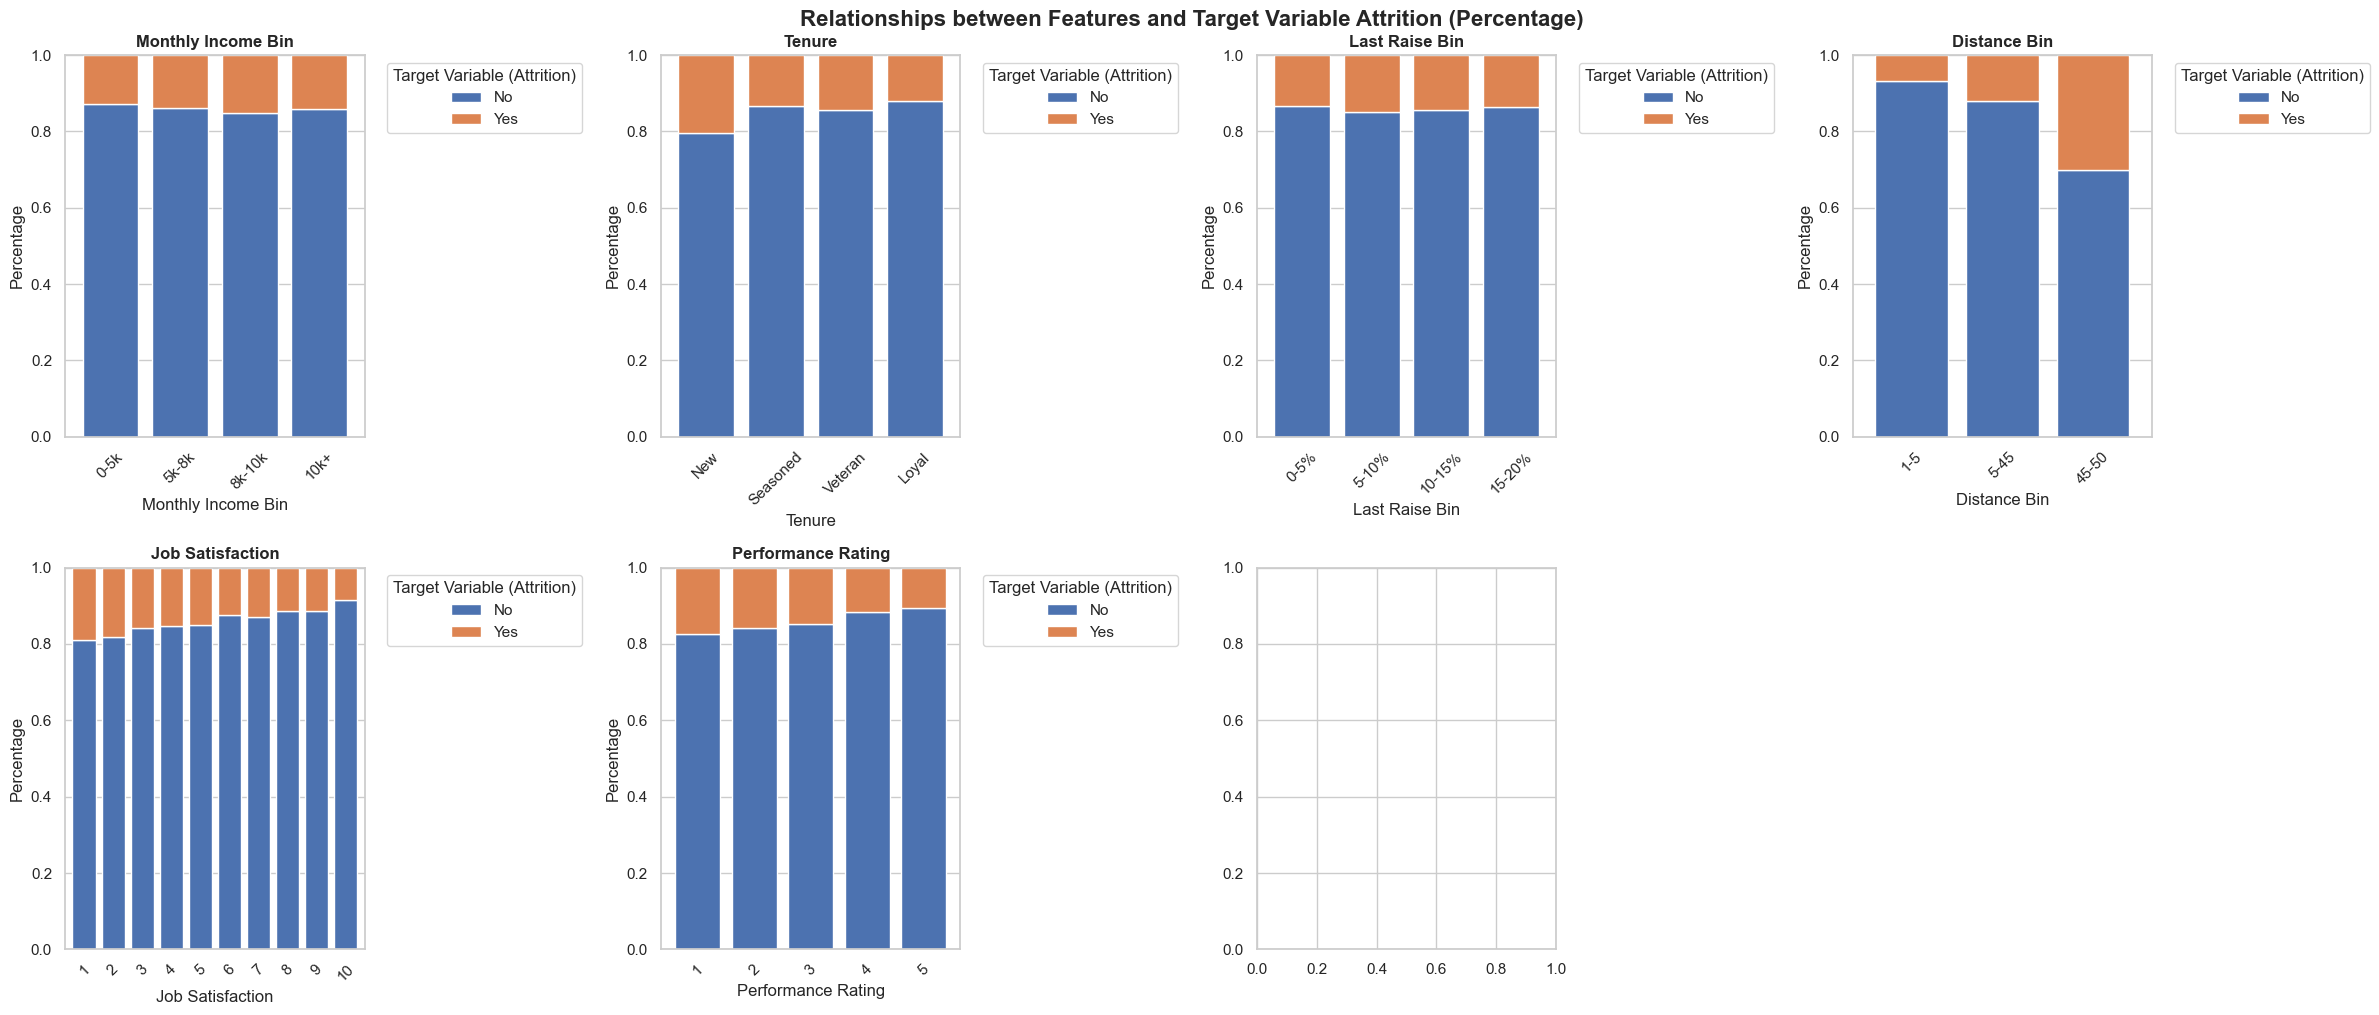

In [223]:
# Creating New Columns
df['Tenure'] = bin_data(df['Years at Company'], 
                                 bins=[0, 2, 8, 19, 30], 
                                 labels=['New', 'Seasoned', 'Veteran', 'Loyal'])

df['Monthly Income Bin'] = bin_data(df['Monthly Income'], 
                                 bins=[0, 5000, 8000, 10000, 15000], 
                                 labels=['0-5k', '5k-8k', '8k-10k', '10k+'])

df['Distance Bin'] = bin_data(df['Distance from Office'], 
                                 bins=[1, 5, 45, 50], 
                                 labels=['1-5', '5-45', '45-50'])

df['Last Raise Bin'] = bin_data(df['Last Raise Percentage'], 
                                 bins=[0, 5, 10, 15, 20], 
                                 labels=['0-5%', '5-10%', '10-15%', '15-20%'])

df['Income per Year'] = df['Monthly Income'] / df['Years at Company']

df['Promotions per Year'] = df['Number of Promotions'] / df['Years at Company']

# 2. Relationships between features and the target variable
# Update features lists
numerical_features = ['Monthly Income Bin','Tenure', 'Last Raise Bin', 'Distance Bin', 'Job Satisfaction', 'Performance Rating']
binary_features = ['Got Promoted'] 

# Calculate the number of rows and columns for the subplot grid
n_numerical = len(numerical_features)
n_binary = len(binary_features)
n_cols = 4
n_rows = -(-n_numerical // n_cols) + -(-n_binary // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Relationships between Features and Target Variable', fontsize=16, fontweight='bold')

# Plot relationships for numerical features
for i, feature in enumerate(numerical_features):
    row, col = divmod(i, n_cols)
    sns.countplot(x=feature, hue='Attrition', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Number of Individuals')
    axes[row, col].legend(title='Target Variable (Attrition)', labels=['No', 'Yes'])
    axes[row, col].tick_params(axis='x', rotation=45)

# Plot relationships for binary features
start_row = -(-n_numerical // n_cols)  # Ceiling division
for i, feature in enumerate(binary_features):
    row, col = divmod(i, n_cols)
    row += start_row
    sns.countplot(x=feature, hue='Attrition', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Number of Individuals')
    axes[row, col].legend(title='Target Variable (Attrition)', labels=['No', 'Yes'])

# Remove any unused subplots
for i in range(n_numerical + n_binary, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust to make room for the suptitle
plt.show()

# 3. Relationships between features and the target variable (Percentage Stacked Bar Charts)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 5*n_rows))  # Increased figure width
fig.suptitle('Relationships between Features and Target Variable Attrition (Percentage)', fontsize=16, fontweight='bold')

# Function to create percentage stacked bar chart
def percentage_stacked_bar(feature, ax):
    # Calculate percentages
    percentages = df.groupby(feature, observed=True)['Attrition'].value_counts(normalize=True).unstack()
    # Plot stacked bar chart
    percentages.plot(kind='bar', stacked=True, ax=ax, width=0.8)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Percentage')
    ax.set_title(f'{feature}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Move legend outside the plot
    ax.legend(title='Target Variable (Attrition)', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot relationships for numerical features
for i, feature in enumerate(numerical_features):
    row, col = divmod(i, n_cols)
    percentage_stacked_bar(feature, axes[row, col])

# Plot relationships for binary features
start_row = -(-n_numerical // n_cols)  # Ceiling division
for i, feature in enumerate(binary_features):
    row, col = divmod(i, n_cols)
    row += start_row
    percentage_stacked_bar(feature, axes[row, col])

# Remove any unused subplots
for i in range(n_numerical + n_binary, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.subplots_adjust(top=0.95, right=0.9)  # Adjust to make room for the suptitle and legends
plt.show()

Step 8: Chi-Square Test

Explanation: Simple test to further see which of the categorical columns can be used to predict Attrition.

Result: Department and Gender do not seem relevant given the bad p-value scores. The p-valye for Job Role is not the best, but we will keep this in mind. Chi2 results are also very low across the board, but they're meant to be relative so we will keep an open mind.

In [224]:
# List of categorical columns to test
categorical_columns = ['Gender', 'Job Role', 'Department']

# Target variable
target = 'Attrition'

# Perform Chi-Square test
chi2_results = {}
for column in categorical_columns:
    contingency_table = pd.crosstab(df[column], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[column] = {'chi2': chi2, 'p-value': p}

# Convert results to DataFrame
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index').reset_index()
chi2_results_df.columns = ['Feature', 'Chi2', 'p-value']

# Sort results by Chi2 score in descending order, then by p-value
chi2_results_df.sort_values(by=['Chi2', 'p-value'], ascending=[False, True], inplace=True)
chi2_results_df.reset_index(drop=True, inplace=True)

# Display the results
print(chi2_results_df)

      Feature      Chi2   p-value
0    Job Role  8.494263  0.075061
1  Department  2.826262  0.587308
2      Gender  2.639567  0.104232


HYPOTHESIS
==============

Employees are more likely to leave if they are further away (Distance), and have lower Job Satisfaction and Performance Ratings. Monthly Income (or their variants of Income per Year and/or Promotions per Year) should also logically be important, but their impact will be tested.


Modelling I - Logistic Regression

In [225]:
# Define feature columns and target variable
feature_columns = ['Monthly Income', 'Years at Company', 'Number of Promotions', 'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_0 = precision_score(y_test, y_pred, pos_label=0)
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_0 = f1_score(y_test, y_pred, pos_label=0)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision for class 0: {precision_0:.4f}')
print(f'Recall for class 0: {recall_0:.4f}')
print(f'F1 Score for class 0: {f1_0:.4f}')
print(f'Precision for class 1: {precision_1:.4f}')
print(f'Recall for class 1: {recall_1:.4f}')
print(f'F1 Score for class 1: {f1_1:.4f}')

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8615
Precision for class 0: 0.8630
Recall for class 0: 0.9977
F1 Score for class 0: 0.9255
Precision for class 1: 0.4286
Recall for class 1: 0.0109
F1 Score for class 1: 0.0212
Confusion Matrix:
[[1720    4]
 [ 273    3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1724
           1       0.43      0.01      0.02       276

    accuracy                           0.86      2000
   macro avg       0.65      0.50      0.47      2000
weighted avg       0.80      0.86      0.80      2000



C:\Users\ekreklinuman\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Modelling I - Logistic Regression

Result: Very poor Recall and Precision for Minority Class.

In [226]:
# all_columns = ['Monthly Income', 'Years at Company', 'Number of Promotions', 'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 'Performance Rating']

# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Job Satisfaction', 'Years at Company', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {'Logistic Regression': LogisticRegression()}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, accuracy, precision, recall, f1])

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1724    0]
 [ 276    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1724
           1       0.00      0.00      0.00       276

    accuracy                           0.86      2000
   macro avg       0.43      0.50      0.46      2000
weighted avg       0.74      0.86      0.80      2000



C:\Users\ekreklinuman\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ekreklinuman\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ekreklinuman\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Model II: KNN

Result: Very poor Recall and Precision for Minority Class.

In [227]:
# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Job Satisfaction', 'Years at Company', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {'KNN': KNeighborsClassifier()}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, accuracy, precision, recall, f1])

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1662   62]
 [ 247   29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1724
           1       0.32      0.11      0.16       276

    accuracy                           0.85      2000
   macro avg       0.59      0.53      0.54      2000
weighted avg       0.79      0.85      0.81      2000



Model 3: Gradient Boosting

Result: Very poor Recall and Precision for Minority Class.

In [228]:
# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Job Satisfaction', 'Years at Company', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {'Gradient Boosting': GradientBoostingClassifier()}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, accuracy, precision, recall, f1])

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1697   27]
 [ 257   19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1724
           1       0.41      0.07      0.12       276

    accuracy                           0.86      2000
   macro avg       0.64      0.53      0.52      2000
weighted avg       0.81      0.86      0.81      2000



Model 4: Random Forest

Result: Very poor Recall and Precision for Minority Class.

In [229]:
# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Job Satisfaction', 'Years at Company', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {'Random Forest': RandomForestClassifier()}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, accuracy, precision, recall, f1])

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1676   48]
 [ 248   28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1724
           1       0.37      0.10      0.16       276

    accuracy                           0.85      2000
   macro avg       0.62      0.54      0.54      2000
weighted avg       0.80      0.85      0.81      2000



Picked Gradient Boosting to optimize. Optimizations as below:

- Set Threshold to 0.145 to improve scores for the minority class. This will result in an overall lower accuracy.
- Adjusting class weights to give more weight to the minority class.

Result: Accuracy goes down to 70%, but much better results for Minroity class. Recall for 1 is still not great at only 50%, so further optimization will be attempted.

In [230]:
# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Job Satisfaction', 'Years at Company', 'Performance Rating']
target_variable = 'Attrition'

# Split the data
X = df[feature_columns]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adjust class weights
class_weight = {0: 1, 1: 5}  # Giving more weight to the minority class

# Define the models
models = {'Gradient Boosting': GradientBoostingClassifier()}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, accuracy, precision, recall, f1])

# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Set a custom threshold
threshold = 0.145
y_pred = (y_probs >= threshold).astype(int)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1263  461]
 [ 138  138]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1724
           1       0.23      0.50      0.32       276

    accuracy                           0.70      2000
   macro avg       0.57      0.62      0.56      2000
weighted avg       0.81      0.70      0.74      2000



Developing the Final Model with Big Adjustments:
- Applied Scaler to Scale the Features
- Applied SMOTE to get oversample and get better scores for Minority Class
- Adjusted Hyperparameters
- Readjusted Threshold to 0.23
- Readded "Age" feature for slightly more balanced results
- Added Random Forest Model to create an Ensemble Model at the end
- Added Income per Year and Promotions per Year as features into the model
- Gradient Boosting has more weight than Random Forest (by 1.6)
- Added Cross Validation to ensure that model can work with future data

In [231]:
# Define feature columns and target variable
feature_columns = ['Distance from Office', 'Age', 'Job Satisfaction', 'Income per Year', 'Promotions per Year', 'Performance Rating']
target_variable = 'Attrition'

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE with increased sampling ratio
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Adjust class weights
class_weight = {0: 1, 1: 5}  # Giving more weight to the minority class

# Define models with adjusted hyperparameters
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, class_weight=class_weight, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42)

models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

# Function to evaluate model with lower threshold
def evaluate_model(y_true, y_pred_proba, threshold=0.23):
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_0': precision_score(y_true, y_pred, pos_label=0),
        'Recall_0': recall_score(y_true, y_pred, pos_label=0),
        'F1_Score_0': f1_score(y_true, y_pred, pos_label=0),
        'Precision_1': precision_score(y_true, y_pred, pos_label=1),
        'Recall_1': recall_score(y_true, y_pred, pos_label=1),
        'F1_Score_1': f1_score(y_true, y_pred, pos_label=1)
    }

# Train and evaluate individual models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_val_pred_proba = model.predict_proba(X_val_scaled)
    val_results = evaluate_model(y_val, y_val_pred_proba)
    
    y_test_pred_proba = model.predict_proba(X_test_scaled)
    test_results = evaluate_model(y_test, y_test_pred_proba)
    
    results[name] = {'Validation': val_results, 'Test': test_results}

# Create and train the ensemble model
print("Training Ensemble Model...")
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting'])
    ],
    voting='soft',
    weights=[1, 2]  # Giving more weight to Gradient Boosting 
)

ensemble_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the ensemble model
y_val_pred_proba_ensemble = ensemble_model.predict_proba(X_val_scaled)
val_results_ensemble = evaluate_model(y_val, y_val_pred_proba_ensemble)

y_test_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)
test_results_ensemble = evaluate_model(y_test, y_test_pred_proba_ensemble)

results['Ensemble'] = {'Validation': val_results_ensemble, 'Test': test_results_ensemble}

# Prepare data for tabulate
table_data = []
headers = ['Model', 'Dataset', 'Accuracy', 'Precision_0', 'Recall_0', 'F1_Score_0', 'Precision_1', 'Recall_1', 'F1_Score_1']

for model_name, model_results in results.items():
    for dataset in ['Validation', 'Test']:
        row = [model_name, dataset] + [f"{value:.4f}" for value in model_results[dataset].values()]
        table_data.append(row)

# Print results using tabulate
print("\nModel Performance Results:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Cross-validation
print("\nPerforming Cross-Validation:")
cv_scores = {}

for name, model in models.items():
    cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_scores[name] = cv_score
    print(f"{name} - Mean CV Accuracy: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")

# Cross-validation for ensemble model
cv_score_ensemble = cross_val_score(ensemble_model, X, y, cv=5, scoring='accuracy')
cv_scores['Ensemble'] = cv_score_ensemble
print(f"Ensemble - Mean CV Accuracy: {cv_score_ensemble.mean():.4f} (+/- {cv_score_ensemble.std() * 2:.4f})")

Training Random Forest...
Training Gradient Boosting...
Training Ensemble Model...

Model Performance Results:
+-------------------+------------+------------+---------------+------------+--------------+---------------+------------+--------------+
| Model             | Dataset    |   Accuracy |   Precision_0 |   Recall_0 |   F1_Score_0 |   Precision_1 |   Recall_1 |   F1_Score_1 |
+===================+============+============+===============+============+==============+===============+============+==============+
| Random Forest     | Validation |     0.3267 |        0.8997 |     0.2436 |       0.3834 |        0.1529 |     0.8341 |       0.2584 |
+-------------------+------------+------------+---------------+------------+--------------+---------------+------------+--------------+
| Random Forest     | Test       |     0.3213 |        0.8943 |     0.2314 |       0.3677 |        0.1591 |     0.8416 |       0.2676 |
+-------------------+------------+------------+---------------+----------

Summary of Findings

- EDA: The initial hypothesis of income or promotions affecting attrition did not hold true. If there is an impact, it is a lower one, as our model's results did not change with the addition of those features. The remaining features mentioned in the hypothesis were able to achieve a decent Recall 1 score, albeit with lower overall accuracy.

- Approach: The models were built with the intent of identifying those who are likely to leave. This is because a model of 90% accuracy that cannot predict which employees are likely to leave is not particularly useful. Those were the initial results, and lowering the accuracy was necessary to achieve higher identification of those likely to leave. In short, the primary metric here is achieving a high Recall 1 score to identify as many leavers as possible without lowering the overall accuracy of the model too low.

- Usecase: The final ensmble model achieves a Recall 1 Score of around 70%, and this is consistent on both test and validation scores. Cross validation also showcases that the model is not overfitted. However, the Accuracy of the model is only 46%, which means that the final model over predicts that employees are going to leave.

The business should use the final output of the model to help alleviate those who are likely to leave. A 90% score on Precision 0 indicates that the executives can trust the model when it predicts that the employee is not going to leave. Hence, resources can be safely moved away from those employees and shifted comfortably towards those that the model predicts as 1 (or those who will leave). Given the overall low accuracy of the model, the business will spend more funds and resources than ideal (as quite a few funds will be spent on false positives), but it will still be better than having no prediction and losing those employees in the first place.